# ONLY OvR !

In [4]:
%load_ext autoreload
%autoreload 2

# Results

In [5]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

## Small-scale experiments

### Initialize

#### Variables

In [18]:
SCALE = 'SmallScale'
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = 10

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [19]:
ARCHITECTURE = 'LeNet'   
sm_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [20]:
ARCHITECTURE = 'LeNet'          
eos_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg 40k)'},
]

#### Evaluation data from OvR

In [21]:
ARCHITECTURE = 'LeNet'   
ovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [22]:
ARCHITECTURE = 'LeNet'          
ovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OvR'], 'label': 'OvR-F (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OvR'], 'label': 'OvR-H (0)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H (0.4)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OvR'], 'label': 'OvR-H (0.8)'}],
}

In [23]:
ARCHITECTURE = 'LeNet'
ovr_data_info_3_T_10k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OvR'], 'label': 'OvR (w/ neg 10k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 10k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 10k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 10k)'}],
}
ovr_data_info_3_T_20k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OvR'], 'label': 'OvR (w/ neg 20k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 20k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 20k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 20k)'}],
}
ovr_data_info_3_T_30k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OvR'], 'label': 'OvR (w/ neg 30k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 30k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 30k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 30k)'}],
}
ovr_data_info_3_T = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg 40k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg 40k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 40k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 40k)'}],
}

In [9]:
# ARCHITECTURE = 'LeNet'   
# ovr_data_info_test = [
#     {'info':[SCALE, '_Discussion', f'{ARCHITECTURE}_test_neg_0', 'OvR'], 'label': 'OvR'},
#     {'info':[SCALE, '_Discussion', f'{ARCHITECTURE}_test_neg_10000', 'OvR'], 'label': 'OvR'},
#     {'info':[SCALE, '_Discussion', f'{ARCHITECTURE}_test_neg_20000', 'OvR'], 'label': 'OvR'},
#     {'info':[SCALE, '_Discussion', f'{ARCHITECTURE}_test_neg_30000', 'OvR'], 'label': 'OvR'},
#     {'info':[SCALE, '_Discussion', f'{ARCHITECTURE}_test_neg_-1', 'OvR'], 'label': 'OvR'},
# ]

### 0. Tuning

#### Loss weighting parameter - neg 0
- Best C OvR : global 
- Best F OvR : 2
- Best M OvR : 0.4

In [10]:
# Class balancing - batch/global
data_info = ovr_data_info_2_T['C']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.8641	0.8624	0.8224	0.0500	0.0346	1.0831	1.1520
0.8711	0.8697	0.8187	0.0510	0.0249	1.0334	1.1194


In [11]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_2_T['F']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.8797	0.8843	0.8437	0.0910	0.0106	0.6722	0.8149
0.8470	0.8478	0.8036	0.0880	0.0132	0.7347	0.8144
0.8853	0.8877	0.8301	0.0760	0.0102	0.6885	0.8272
0.8909	0.8892	0.8357	0.0790	0.0060	0.6380	0.8093
0.8907	0.8914	0.8345	0.0850	0.0077	0.6462	0.7899


In [12]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_2_T['M']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.8686	0.8663	0.8224	0.1040	0.0088	0.6613	0.7831
0.8674	0.8676	0.8207	0.0800	0.0164	0.8102	0.8661
0.8775	0.8785	0.8156	0.0620	0.0242	0.9388	1.0457
0.8523	0.8498	0.7685	0.0630	0.0240	0.9468	1.0751
0.8539	0.8528	0.8121	0.0540	0.0220	1.0334	1.0572


#### Loss weighting parameter - neg All
- Best C OvR : batch 
- Best F OvR : 1
- Best M OvR : 0.2

In [13]:
# Class balancing - batch/global
data_info = ovr_data_info_3_T['C']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.9789	0.9801	0.8605	0.1770	0.0120	0.0241	0.3970
0.9786	0.9785	0.8576	0.1920	0.0111	0.0238	0.3990


In [14]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_3_T['F']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.9784	0.9791	0.8582	0.2430	0.0086	0.0173	0.3595
0.9783	0.9785	0.8597	0.2170	0.0091	0.0207	0.3719
0.9785	0.9786	0.8544	0.2840	0.0070	0.0159	0.3509
0.9772	0.9784	0.8568	0.3120	0.0071	0.0130	0.3444
0.9776	0.9789	0.8609	0.2650	0.0068	0.0169	0.3580


In [15]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_3_T['M']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.9785	0.9798	0.8498	0.2380	0.0076	0.0156	0.3868
0.9793	0.9788	0.8511	0.2500	0.0077	0.0162	0.3628
0.9789	0.9782	0.8529	0.2430	0.0081	0.0184	0.3803
0.9791	0.9782	0.8555	0.1930	0.0111	0.0245	0.3890
0.9785	0.9792	0.8601	0.1940	0.0100	0.0225	0.3945


### Metrics Plots


In [16]:
base_data_info = []
base_data_info.append(sm_data_info_1[0])
base_data_info.append(eos_data_info_3[-1])

for idx in range(len(base_data_info)):
    print(base_data_info[idx]['info'])

base_results = evals.print_metrics(base_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [17]:
ovr_data_info = []
ovr_data_info.append(ovr_data_info_1[0])
ovr_data_info.append(ovr_data_info_3_T_10k['base'][0])
ovr_data_info.append(ovr_data_info_3_T_20k['base'][0])
ovr_data_info.append(ovr_data_info_3_T_30k['base'][0])
ovr_data_info.append(ovr_data_info_3_T['base'][0])

for idx in range(len(ovr_data_info)):
    print(ovr_data_info[idx]['info'])

ovr_results = evals.print_metrics(ovr_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [18]:
c_data_info = []
c_data_info.append(ovr_data_info_2_T['C'][1])
c_data_info.append(ovr_data_info_3_T_10k['C'][0])
c_data_info.append(ovr_data_info_3_T_20k['C'][0])
c_data_info.append(ovr_data_info_3_T_30k['C'][0])
c_data_info.append(ovr_data_info_3_T['C'][0])

for idx in range(len(c_data_info)):
    print(c_data_info[idx]['info'])

c_results = evals.print_metrics(c_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [19]:
f_data_info = []
f_data_info.append(ovr_data_info_2_T['F'][3])
f_data_info.append(ovr_data_info_3_T_10k['F'][2])
f_data_info.append(ovr_data_info_3_T_20k['F'][2])
f_data_info.append(ovr_data_info_3_T_30k['F'][2])
f_data_info.append(ovr_data_info_3_T['F'][2])

for idx in range(len(f_data_info)):
    print(f_data_info[idx]['info'])

f_results = evals.print_metrics(f_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [20]:
h_data_info = []
h_data_info.append(ovr_data_info_2_T['M'][2])
h_data_info.append(ovr_data_info_3_T_10k['M'][1])
h_data_info.append(ovr_data_info_3_T_20k['M'][1])
h_data_info.append(ovr_data_info_3_T_30k['M'][1])
h_data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(h_data_info)):
    print(h_data_info[idx]['info'])

h_results = evals.print_metrics(h_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


Text(0.5, 1.0, 'False Positive Rate\nfor other Known classes')

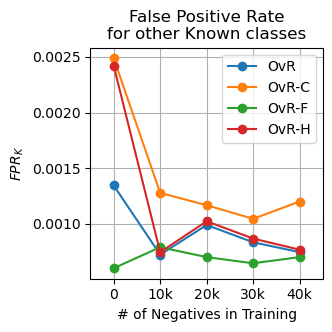

In [21]:
ovr_fpr_nt = [item['fpr_nt_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_nt_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_nt_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_nt_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('$FPR_K$')
plt.grid('both')
# plt.title("$FPR_K$ vs. Negatives in Training")
plt.title("False Positive Rate\nfor other Known classes")

Text(0.5, 1.0, 'False Positive Rate\nfor Unknown classes')

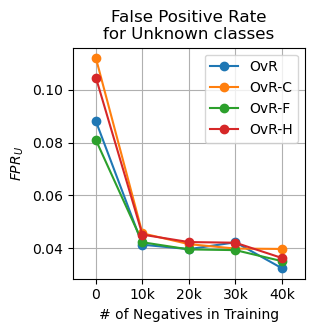

In [22]:
ovr_fpr_nt = [item['fpr_u_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_u_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_u_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_u_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('$FPR_U$')
plt.grid('both')
# plt.title('Unknown')
plt.title("False Positive Rate\nfor Unknown classes")

Text(0.5, 1.0, 'False Positive Rate\nfor Negative classes')

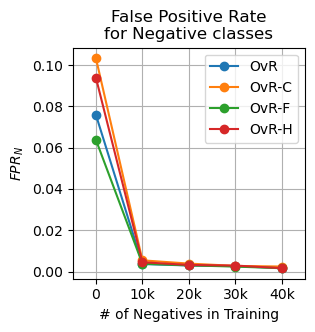

In [23]:
ovr_fpr_nt = [item['fpr_n_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_n_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_n_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_n_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('$FPR_N$')
plt.grid('both')
# plt.title('Negative')
plt.title("False Positive Rate\nfor Negative classes")

Text(0.5, 1.0, '\nFalse Negative Rate')

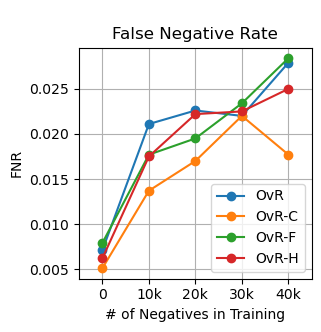

In [24]:
ovr_fpr_nt = [item['fnr_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fnr_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fnr_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fnr_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('FNR')
plt.grid('both')
# plt.title('Target')
plt.title("\nFalse Negative Rate")

Text(0.5, 1.0, 'Max Open-Set Accuracy\nwith Testset Negative ($D_K \\cup D_N$)')

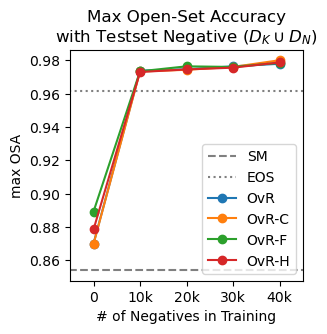

In [25]:
ovr_fpr_nt = [item['iosa_neg'] for item in ovr_results['oosa']]
c_fpr_nt = [item['iosa_neg'] for item in c_results['oosa']]
f_fpr_nt = [item['iosa_neg'] for item in f_results['oosa']]
h_fpr_nt = [item['iosa_neg'] for item in h_results['oosa']]

plt.figure(figsize=(3,3))

# Baseline
base_fpr_nt = [item['iosa_neg'] for item in base_results['oosa']]

plt.hlines(base_fpr_nt[0], xmin=-1, xmax=5, label='SM', linestyles='--', color='grey')
plt.hlines(base_fpr_nt[1], xmin=-1, xmax=5, label='EOS', linestyles=':', color='grey')

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
# plt.ylim((0.80,1))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('max OSA')
plt.title('Max Open-Set Accuracy\nwith Testset Negative ($D_K \cup D_N$)')

Text(0.5, 1.0, 'Max Open-Set Accuracy\nwith Testset Unknown ($D_K \\cup D_U$)')

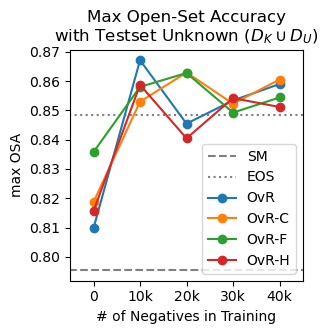

In [26]:
ovr_fpr_nt = [item['iosa_unkn'] for item in ovr_results['oosa']]
c_fpr_nt = [item['iosa_unkn'] for item in c_results['oosa']]
f_fpr_nt = [item['iosa_unkn'] for item in f_results['oosa']]
h_fpr_nt = [item['iosa_unkn'] for item in h_results['oosa']]

plt.figure(figsize=(3,3))

# Baseline
base_fpr_nt = [item['iosa_unkn'] for item in base_results['oosa']]

plt.hlines(base_fpr_nt[0], xmin=-1, xmax=5, label='SM', linestyles='--', color='grey')
plt.hlines(base_fpr_nt[1], xmin=-1, xmax=5, label='EOS', linestyles=':', color='grey')

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
# plt.ylim((0.80,1))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('max OSA')
plt.title('Max Open-Set Accuracy\nwith Testset Unknown ($D_K \cup D_U$)')

### OSA Plots


In [27]:
no_neg_data_info = []
no_neg_data_info.append(sm_data_info_1[0])
no_neg_data_info.append(ovr_data_info_1[0])
no_neg_data_info.append(ovr_data_info_2_T['C'][1])
no_neg_data_info.append(ovr_data_info_2_T['F'][3])
no_neg_data_info.append(ovr_data_info_2_T['M'][2])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

no_neg_results = evals.print_metrics(no_neg_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [28]:
neg_data_info = []
neg_data_info.append(eos_data_info_3[-1])
neg_data_info.append(ovr_data_info_3_T['base'][0])
neg_data_info.append(ovr_data_info_3_T['C'][0])
neg_data_info.append(ovr_data_info_3_T['F'][2])
neg_data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

neg_results = evals.print_metrics(neg_data_info, is_verbose=False)

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


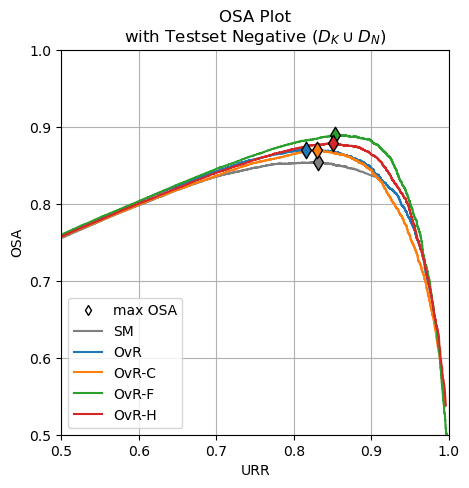

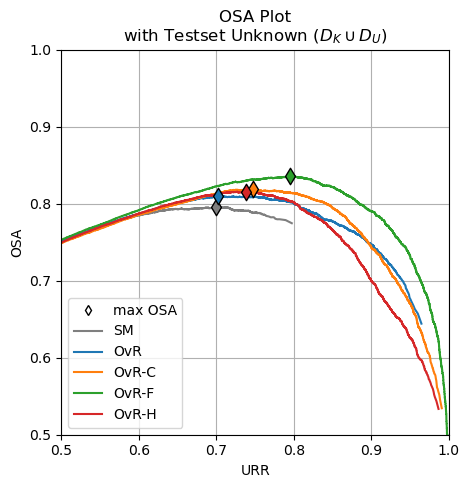

In [29]:
labels = ['SM', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(no_neg_data_info)-1]
evals.plot_OSA(no_neg_data_info, colors, labels = labels, figsize = (5,5), lim=((0.5,1),(0.5,1)),
               show_point=(False, True))

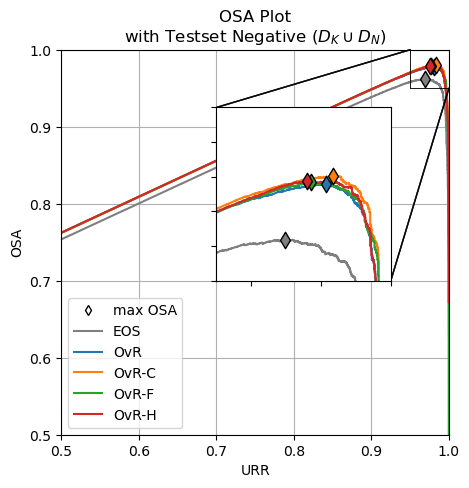

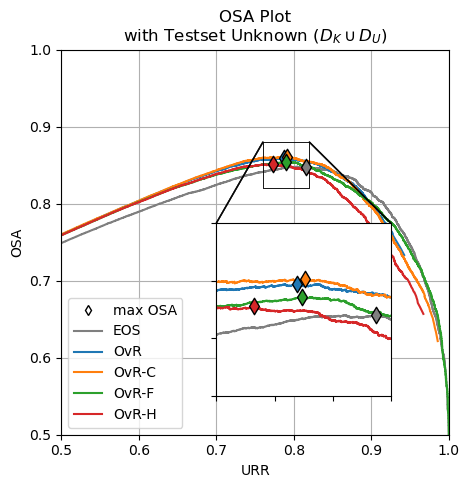

In [30]:
labels = ['EOS', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(neg_data_info)-1]
evals.plot_OSA(neg_data_info, colors, labels=labels, figsize = (5,5), lim=((0.5,1),(0.5,1)),
               show_point=(False, True),
               zoom=((True, (0.95,1.0,0.95,1.0),(0.4,0.4,0.45,0.45)), 
                     (True, (0.76,0.82,0.82,0.88),(0.4,0.1,0.45,0.45))))

### RQ 1 and 2

In [29]:
data_info = []
data_info.append(sm_data_info_1[0])
data_info.append(ovr_data_info_1[0])
data_info.append(ovr_data_info_2_T['C'][1])
data_info.append(ovr_data_info_2_T['F'][3])
data_info.append(ovr_data_info_2_T['M'][2])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']


In [30]:
results_1 = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.8540	0.7954	0.0690	0.0076	0.9969	0.9962


0.8700	0.8098	0.0710	0.0134	0.7590	0.8805
0.8697	0.8187	0.0510	0.0249	1.0334	1.1194
0.8892	0.8357	0.0790	0.0060	0.6380	0.8093
0.8785	0.8156	0.0620	0.0242	0.9388	1.0457


[0.56 0.07 0.03 0.01] [9.916e+01 6.000e-02 4.000e-02 4.000e-02]
[0.43 0.05 0.06 0.02] [97.89  0.3   0.17  0.1 ]
[0.33 0.05 0.05 0.  ] [95.47  0.74  0.5   0.22]
[0.41 0.13 0.05 0.03] [98.4   0.33  0.18  0.17]
[0.28 0.06 0.06 0.03] [95.55  0.7   0.46  0.19]


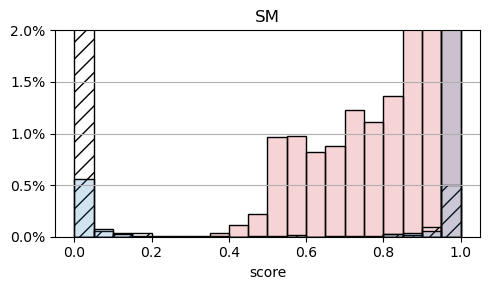

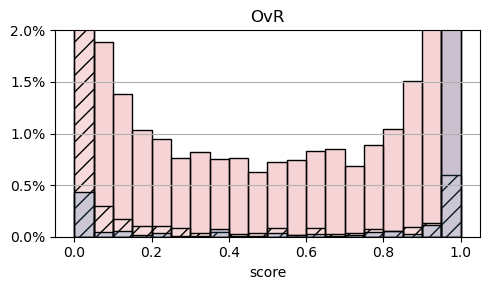

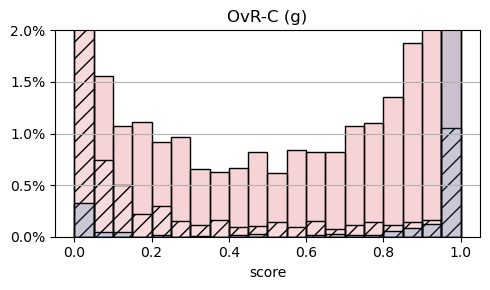

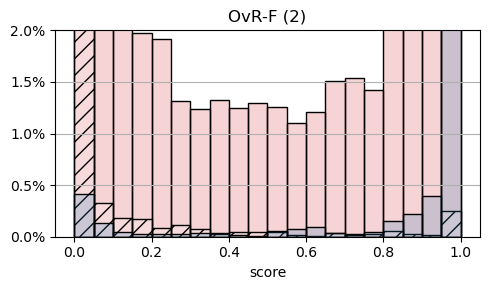

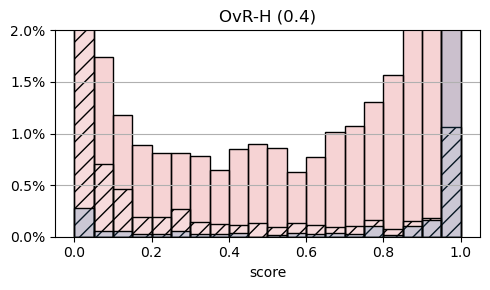

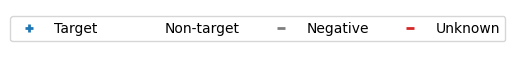

In [69]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=(CMAP_t10[0],'white',CMAP_t10[7],CMAP_t10[3])
alpha = [0.2]*len(colors)
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=list(zip(colors,alpha)), 
                               figsize=(5,3), ylim=(0,2), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[2], lw=0, label=labels[2], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### RQ 3 and 4

#### 10k

In [183]:
data_info = []
data_info.append(ovr_data_info_3_T_10k['base'][0])
data_info.append(ovr_data_info_3_T_10k['C'][0])
data_info.append(ovr_data_info_3_T_10k['F'][2])
data_info.append(ovr_data_info_3_T_10k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']


In [184]:
results_1 = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.9738	0.8671	0.2110	0.0072	0.0361	0.4132
0.9734	0.8529	0.1370	0.0128	0.0541	0.4562
0.9735	0.8580	0.1770	0.0079	0.0377	0.4224
0.9730	0.8587	0.1750	0.0074	0.0449	0.4513


#### 20k

In [185]:
data_info = []
data_info.append(ovr_data_info_3_T_20k['base'][0])
data_info.append(ovr_data_info_3_T_20k['C'][0])
data_info.append(ovr_data_info_3_T_20k['F'][2])
data_info.append(ovr_data_info_3_T_20k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']


In [186]:
results_1 = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.9747	0.8454	0.2260	0.0099	0.0292	0.3964
0.9744	0.8629	0.1700	0.0117	0.0383	0.4152
0.9764	0.8627	0.1950	0.0070	0.0298	0.3953
0.9746	0.8404	0.2220	0.0102	0.0317	0.4232


#### 30k

In [192]:
data_info = []
data_info.append(ovr_data_info_3_T_30k['base'][0])
data_info.append(ovr_data_info_3_T_30k['C'][0])
data_info.append(ovr_data_info_3_T_30k['F'][2])
data_info.append(ovr_data_info_3_T_30k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']


In [193]:
results_1 = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.9764	0.8534	0.2200	0.0083	0.0261	0.4223
0.9761	0.8522	0.2200	0.0104	0.0272	0.3985
0.9761	0.8492	0.2340	0.0064	0.0239	0.3926
0.9756	0.8541	0.2250	0.0087	0.0286	0.4207


#### 40k (All)

In [189]:
data_info = []
data_info.append(eos_data_info_3[-1])
data_info.append(ovr_data_info_3_T['base'][0])
data_info.append(ovr_data_info_3_T['C'][0])
data_info.append(ovr_data_info_3_T['F'][2])
data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


In [190]:
results_1 = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.9619	0.8483	0.4050	0.0139	0.0378	0.4174
0.9780	0.8589	0.2790	0.0074	0.0166	0.3241
0.9801	0.8605	0.1770	0.0120	0.0241	0.3970
0.9786	0.8544	0.2840	0.0070	0.0159	0.3509
0.9788	0.8511	0.2500	0.0077	0.0162	0.3628


#### Legend

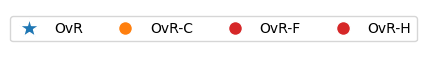

In [191]:
# Composing separate legend plot
labels = ['OvR', 'OvR-C', 'OvR-F', 'OvR-H']
legend_elements = [
    Line2D([0], [0], markerfacecolor=CMAP_t10[0], color='w',marker='*', markersize=15),
    Line2D([0], [0], markerfacecolor=CMAP_t10[1], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, labels = labels, loc='center', ncol=4, 
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.axes.axis("off")
plt.show()